In [1]:
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.python.ops import array_ops

/Users/dlituiev/repos/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load custom functions

In [3]:
from get_data import read_and_dump, get_strand_data, extract_events

from dnahashing import dnahash, dnaunhash, convert_to_nry, hash_window_mapping, crop_hash
from dnahashing import get_transition_matrix

dnaunhash = np.vectorize(dnaunhash)
dnahash = np.vectorize(dnahash)

## Read data
set your data directory!

In [4]:
datadir = "/Users/dlituiev/repos/minion/data/" 
filename_ = "DESKTOP_M6JT9BU_lambda2_raw_2704_1_ch153_read3599_strand.fast5"
filename = os.path.join(datadir, filename_)

here we just read one `.fast5` file. For training we will need to use a function from the `get_data` module:

    events, bases = get_strand_data(filename, strand = "template")

We extract `Event` data frame and `Model` data frame. These frames come out of Metichore software.

In [5]:
strand = "complement"
with h5py.File(filename, "r") as h5:
    prefix_events = "/Analyses/Basecall_1D_000/BaseCalled_{0}/".format(strand)
    "Read EVENTS"
    events = h5[ prefix_events + "Events"]
    #events, bases, tshift, tdrift, tscale, tscale_sd = extract_events(h5 , strand = strand)
    keys = events.dtype.fields.keys()
    events = pd.DataFrame({k: events[k] for k in keys})
    events["model_state"] = events["model_state"].map(lambda x: x.decode())
    "Read MODEL"
    model = h5[ prefix_events + "Model"]
    model = pd.DataFrame({k: model[k] for k in model.dtype.fields.keys()})
    model["kmer"] = model["kmer"].map(lambda x: x.decode())
    "add hash column to the `model` frame"
    model["hash"]  = model.kmer.map(lambda x: dnahash(x, seq_len=6))

#### Exploratory analysis

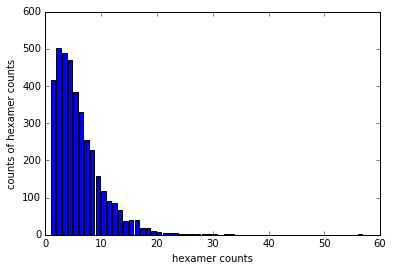

In [6]:
hex_counts = events["model_state"].value_counts().value_counts().sort_index()
plt.bar(hex_counts.index, hex_counts)
plt.xlabel("hexamer counts")
plt.ylabel("counts of hexamer counts")

## Pre-format data

#### Calculate empirical _brute force_ emission parameters from labelled events

In [7]:
#events.groupby(["model_state"]).agg(np.std)/ 
features = events.set_index(["model_state"])[["mean", "stdv"]]
feature_mean_weights = features.groupby(level = 0).agg(np.mean).loc[list(dnaunhash(range(4**6)))]
feature_mean_weights = feature_mean_weights.fillna(feature_mean_weights.mean(0))
feature_mean_weights.to_csv("emission_init.csv")

#### Extract a part from `model` table with emission parameters

In [8]:
model_ftr_weights = model.sort_values("hash").set_index("kmer")[["level_mean","level_stdv"]]#["level_mean"]
model_ftr_weights[:3]
model_ftr_var_weights = model.sort_values("hash").set_index("kmer")[["sd_mean","sd_stdv"]]#["level_mean"]
model_ftr_var_weights[:3]
# no idea what this parameter is:
# feature_mix_weights = model.sort_values("hash").set_index("kmer")["weight"]
# feature_mix_weights[:3]

,sd_mean,sd_stdv
kmer,,
AAAAAA,0.738710,0.250211
AAAAAT,0.923557,0.349777
AAAAAC,0.820361,0.292821


# Define HMM functions: emission, transition, fw and rv steps

In [9]:
def emission(x, W_emit, log_x_inv_var_emitted, mix_weight = None, hidden_layer_size = 4**6, n_features = 2):
    sqrt2pi = np.sqrt(2*np.pi)
    with tf.variable_scope("HMM"):
        with tf.variable_scope("emission"):
            print( [None, W_emit.get_shape()[0], W_emit.get_shape()[1]])
            "W_emit: [input_size, hidden_layer_size]"
            x_inv_var_emitted = tf.exp(log_x_inv_var_emitted)
            print( "W_emit", W_emit.get_shape() )
            print( "x_inv_var_emitted", x_inv_var_emitted.get_shape() )
            print( "x before", x.get_shape() )
            x = tf.reshape(x,  tf.pack([-1, 1, n_features]), name = "x_reshaped")
            print( "x after", x.get_shape() )
            loss_x = 0.5 * ((x - W_emit) * x_inv_var_emitted )**2
            print( "loss_x", loss_x.get_shape() )
            "this should enforce probabilities integrate to one over `x`"
            
            P_x_given_z = tf.reduce_sum(
                                tf.exp( 0.5 * log_x_inv_var_emitted)/sqrt2pi * tf.exp( -loss_x ),
                                reduction_indices = 2, 
                                          )
            
            print( "P_x_given_z", P_x_given_z.get_shape() )
#             P_x_given_z = tf.mul(P_x_given_z, mix_weight)
            P_x_given_z = tf.reshape(P_x_given_z,
                          [-1, hidden_layer_size],
                                    )
            
            print( "P_x_given_z", P_x_given_z.get_shape() )
            """Normalization here is a dirty trick! 
            Normalization constant has to be stored and propageted!"""
            P_x_given_z = P_x_given_z / tf.reshape(
                tf.reduce_sum(P_x_given_z, reduction_indices=1),
                [-1,1])
            return P_x_given_z

In [10]:
def get_transition_weights(stay_prob, forward = True):
    #stay_prob = tf.get_variable("skip", shape=[1], initializer=tf.constant_initializer(skip_init))
    #stay_prob = tf.Variable( np.array(1e-1, dtype=np.float32), name="skip") # .astype(np.float32)
    W_trans = get_transition_matrix().astype(np.float32)
    if forward:
        name = "W_trans_fw"
    else:
        name = "W_trans_bw"
    if not forward:
        W_trans = W_trans.T
    W_trans = W_trans / W_trans.sum(0)
    W_trans = (1 - stay_prob) * W_trans + \
                   stay_prob * np.eye(W_trans.shape[0]).astype(np.float32)
#     W_trans = tf.div(W_trans , tf.reduce_sum(W_trans, reduction_indices=0), name=name)
    print("W_trans", W_trans.get_shape())
    return W_trans

def transition(z_prev_cond_all_prev_x, W_trans, hidden_layer_size):
    with tf.variable_scope("HMM"):
        with tf.variable_scope("transition"):
            h =  tf.reshape( tf.matmul(W_trans, z_prev_cond_all_prev_x),
                            [hidden_layer_size], name='h')
#             h = h / tf.reduce_sum(h)
    return h

In [11]:
"Sandbox"
Wtr = get_transition_weights(tf.Variable(.2))
Wtr = tf.reshape(Wtr, [int(x) for x in Wtr.get_shape()]+ [-1] )
Wtr.get_shape()

W_trans (4096, 4096)


TensorShape([Dimension(4096), Dimension(4096), Dimension(1)])

#### Initialize emission and FW and BW transition matrices
don't run it twice, or you'll get an error

In [12]:
skip_init = 1e-2
emission_init = model_ftr_weights.as_matrix()
emission_var_init = model_ftr_var_weights.as_matrix()
# mix_weight_init = feature_mix_weights.as_matrix()

with tf.variable_scope("HMM/emission"):
    W_emit = tf.Variable(emission_init.astype(np.float32), name = "W_emit", trainable = False)
    
    log_x_inv_var_emitted = tf.Variable( emission_var_init.astype(np.float32),
                                        name="b_emit",
                                        trainable = False)
#     mix_weight = tf.Variable(mix_weight_init.astype(np.float32), name = "mix_emit", trainable = False)

with tf.variable_scope("HMM/transition"):
    stay_prob = tf.get_variable("skip", shape=[1], initializer=tf.constant_initializer(skip_init))
    W_trans_fw = get_transition_weights(stay_prob, forward=True)
    W_trans_bw = get_transition_weights(stay_prob, forward=False)

W_trans (4096, 4096)
W_trans (4096, 4096)


In [13]:
def rnn_step(h_prev, P_x_given_z,
             W_trans, hidden_layer_size = 4**6, n_features = 2):    
    z_prev_cond_all_prev_x = tf.reshape(tf.mul( h_prev , P_x_given_z ),
                                               [hidden_layer_size, 1], name="z_prev_cond_all_prev_x")
    z_prev_cond_all_prev_x = z_prev_cond_all_prev_x / tf.reduce_sum(z_prev_cond_all_prev_x)
    h = transition(z_prev_cond_all_prev_x ,
                   W_trans, hidden_layer_size=hidden_layer_size)
    return h

def rnn_step_fw_with_params(inp, x,):
    return rnn_step(inp, x,
             W_trans_fw, hidden_layer_size = 4**6, n_features = 2)

def rnn_step_bw_with_params(inp, x,):
    return rnn_step(inp, x,
             W_trans_bw, hidden_layer_size = 4**6, n_features = 2)

#### Viterbi: under construction

In [14]:
def viterbi_transition(z_prev_cond_all_prev_x, W_trans, hidden_layer_size):
    """UNDER CONSTRUCTION"""
    with tf.variable_scope("HMM"):
        with tf.variable_scope("transition"):
            h =  tf.reshape( tf.mul(tf.reshape(W_trans, [int(x) for x in W_trans.get_shape()]+ [-1] ),
                                    z_prev_cond_all_prev_x),
                            [hidden_layer_size], name='h')
#             h = h / tf.reduce_sum(h)
    return h

def viterbi_step(h_prev, P_x_given_z,
             W_trans, hidden_layer_size = 4**6, n_features = 2):    
    z_prev_cond_all_prev_x = tf.reshape(tf.mul( h_prev , P_x_given_z ),
                                               [hidden_layer_size, 1], name="z_prev_cond_all_prev_x")
    z_prev_cond_all_prev_x = z_prev_cond_all_prev_x / tf.reduce_sum(z_prev_cond_all_prev_x)
    h = transition(z_prev_cond_all_prev_x ,
                   W_trans, hidden_layer_size=hidden_layer_size)
    return h

#### Define FW and BW probability propagation

In [15]:
from tensorflow.python.ops import functional_ops
init = None
hidden_layer_size = 4**6
if init is None:
    initial_state = tf.ones([hidden_layer_size],
                         name='initial_state')
    initial_state = initial_state/ hidden_layer_size
else:
    initial_state = init
#states = self._rnn_step_fw(initial_state[:,0], self.inputs[0,:])
x = tf.placeholder(np.float32, shape=[None, 2])
"""idea: precompute emissions"""
z_given_x = emission(x, W_emit, log_x_inv_var_emitted)
states_fw = functional_ops.scan(rnn_step_fw_with_params, 
                             tf.identity(tf.concat(0, [tf.ones((1, hidden_layer_size)), z_given_x])),
                             initializer=initial_state, name='states')

states_bw = tf.reverse(
                functional_ops.scan(rnn_step_bw_with_params,
                                    tf.concat(0, [tf.ones((1, hidden_layer_size)),
                                        tf.reverse(z_given_x, [True, False])]),
                             initializer=initial_state, name='states'),
                [True, False]
                    )
# print(states_bw.get_shape())

[None, Dimension(4096), Dimension(2)]
W_emit (4096, 2)
x_inv_var_emitted (4096, 2)
x before (?, 2)
x after (?, ?, ?)
loss_x (?, 4096, 2)
P_x_given_z (?, 4096)
P_x_given_z (?, 4096)


## Feed data into the graph

#### pick a small piece to reduce computation

In [16]:
T = 1000
start = np.random.randint(features.shape[0] - T)
feat_df = features[start:(start+T)]
feat_ = feat_df.as_matrix()

In [17]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
yout = sess.run(z_given_x, feed_dict = {x: feat_})
sess.close()
print("yout.shape:", yout.shape)

yout.shape: (1000, 4096)


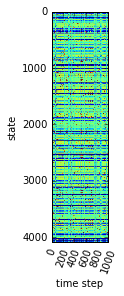

In [18]:
"""Visualize emission probabilities P(hidden_t | x_t)"""
plt.imshow(yout.T, vmin=np.percentile(yout, 2), vmax = np.percentile(yout, 98))
plt.setp( plt.gca().xaxis.get_majorticklabels(), rotation=70 )
plt.tight_layout()
plt.xlabel("time step")
plt.ylabel("state")

#### How our emission model agrees with the Metichore model (using Metichore weghts)?

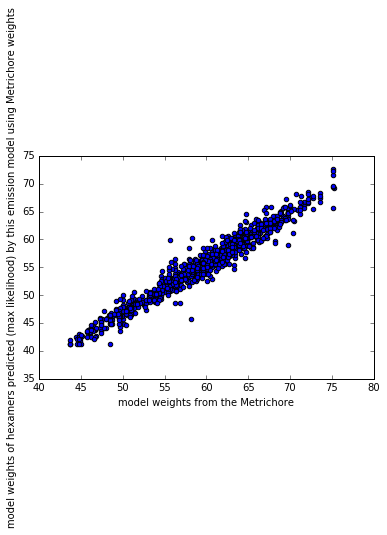

In [19]:
plt.scatter(
    model_ftr_weights.level_mean.loc[(feat_df.index.tolist())],
    model_ftr_weights.level_mean.loc[dnaunhash(np.argmax(yout, axis=1))]
    )
plt.xlabel("model weights from the Metrichore")
plt.ylabel("model weights of hexamers predicted (max likelihood) by this emission model using Metrichore weights")

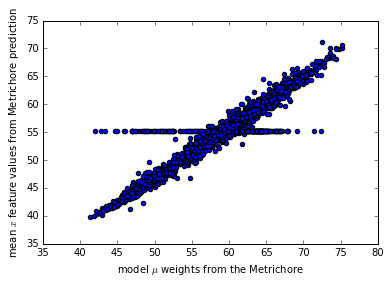

In [20]:
plt.scatter(
    model_ftr_weights.level_mean.loc[dnaunhash( range(4**6))],
    feature_mean_weights["mean"].loc[dnaunhash( range(4**6))],
    )

plt.xlabel("model $\mu$ weights from the Metrichore")
plt.ylabel("mean $x$ feature values from Metrichore prediction")

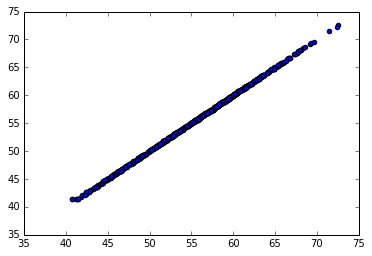

In [21]:
plt.scatter(
    feat_df["mean"],
    model_ftr_weights.level_mean.loc[dnaunhash(np.argmax(yout, axis=1))]
    )

In [22]:
dnahash(events["model_state"][start:(start+T)]).shape

(1000,)

In [23]:
dnahash = np.vectorize(dnahash)
ground_truth_prob = yout[ np.arange(yout.shape[0]), dnahash(events["model_state"][start:(start+T)]),]
ground_truth_prob.shape

(1000,)

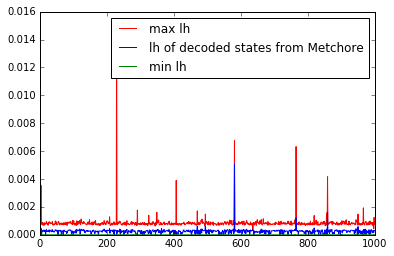

In [24]:
t_ = np.arange(yout.shape[0])
fig, ax = plt.subplots()
ax.plot(t_, np.max(yout, axis=1), "r-", label = "max lh")
ax.plot(t_,
        ground_truth_prob, "b-", label = "lh of decoded states from Metchore"
        )
ax.plot(t_, np.min(yout, axis=1), "g-", label = "min lh")
ax.legend()

## Compute FW-BW

In [25]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
#yout = sess.run(y, feed_dict = {x: feat_})

hidden_states_fw_bw = tf.mul(tf.slice(states_fw, [1, 0], [T, hidden_layer_size]),
                             tf.slice(states_bw, [0, 0], [T, hidden_layer_size]))
#                       tf.mul(z_given_x,       )

z = sess.run(hidden_states_fw_bw, feed_dict = {x: feat_})
sess.close()

#### only forward

In [26]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
states_fw_ev = sess.run(states_fw, feed_dict = {x: feat_})
sess.close()

In [27]:
states_fw_ev.sum(1)

array([ 1.        ,  1.        ,  1.00000048, ...,  1.        ,
        0.9999997 ,  1.00000024], dtype=float32)

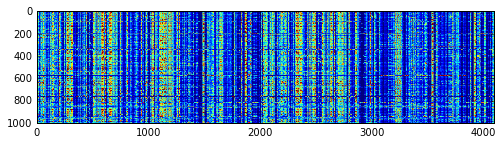

In [28]:
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(z, vmin=np.percentile(z, 2), vmax = np.percentile(z, 98))

In [29]:
def takemax(x):
    y = np.zeros_like(x)
    tmp = np.argmax(x,axis=1)
    y[np.arange(z.shape[0]), tmp] = 1
    return y

In [30]:
# dnaunhash(np.argmax((get_transition_matrix().dot(takemax(z).T)).T, axis=1))


In [31]:
dnaunhash(np.argmax(z,axis=1))[:4]

array(['CTCATG', 'GCTCAC', 'TGCATA', 'AAGTGC'], 
      dtype='<U6')

In [32]:
# np.argmax(hidden_states, axis=1)

In [33]:
h0 = tf.placeholder(np.float32, name="h0", shape=[ 4**6, 1])
h1 = transition(h0, W_trans_fw, 4**6)

h0_ =np.zeros((4**6, 1))
h0_[3073] = 1.0

sess = tf.Session()
sess.run(tf.initialize_all_variables())
#yout = sess.run(y, feed_dict = {x: feat_})

h1_ = sess.run(h1, feed_dict = {h0: h0_})
sess.close()

In [34]:
sum(h1_)

1.0000000093132257

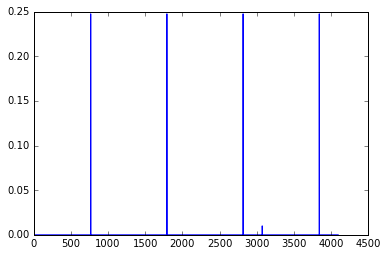

In [35]:
plt.plot(h1_)

In [37]:
sum(dnaunhash(np.argmax(yout, axis=1)) == np.asarray(feat_df.index.get_values(), dtype='<U6'))

0

In [39]:
np.vstack([dnaunhash(np.argmax(yout, axis=1)) , np.asarray(feat_df.index.get_values(), dtype='<U6')]).T[:10]

array([['GGAACC', 'AATCGA'],
       ['CGCTCG', 'AATCGA'],
       ['TTGCTT', 'AATCGA'],
       ['TGTGCG', 'AATCGA'],
       ['GGAGGC', 'ATCGAT'],
       ['CCCTGC', 'TCGATT'],
       ['AATTTC', 'CGATTT'],
       ['CCGTTG', 'GATTTA'],
       ['GAATTC', 'GATTTA'],
       ['TGAATG', 'TTTAGC']], 
      dtype='<U6')

In [51]:
model_ftr_weights.shape

(4096, 2)

## How much variance can be explained by just two nucleotides?

4.03161538868


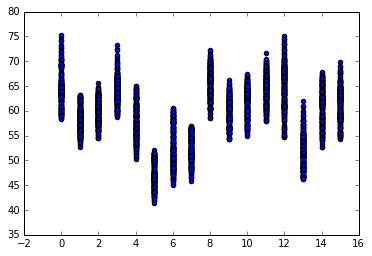

In [53]:
fro = 1
lng = 2
to = fro + lng

chash = np.array([crop_hash(y, fro=fro, to=to ) for y in range(4**6)])
plt.scatter(
    chash,
    model_ftr_weights["level_mean"]
    )

y = model_ftr_weights["level_mean"]
totvar = y.var()
grvar = 0
for nn in range(4**lng):
    grvar += y[chash == nn].var() / totvar
print(grvar)

In [56]:
np.where(events["model_state"] == "GGTGTT")

(array([ 1932,  7117, 10163, 14172, 14173, 18778, 19373, 19475]),)